A deeper dive into the grants flagged as being to do with tech grants

- where do the tech grants sit in the reduced landscape?
- what are the most and least techy clusters (most and least proportion of tech grants in cluster) and where are they?
- what are the thematic areas?
- what are the biggest grants and clusters in terms of amount awarded?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import bokeh.plotting as bpl
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.models import BoxZoomTool, WheelZoomTool, HoverTool, Label
from bokeh.palettes import d3
from bokeh.io import output_file, reset_output, save, export_png
from bokeh.resources import CDN
from bokeh.embed import file_html

bpl.output_notebook()

Loading BokehJS ...

In [3]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from nutrition_labels.cluster_tech_grants import load_cluster, get_cluster_keys

## Load clusters and grant data

In [6]:
datestamp = '200911'
cluster_grant_data = pd.read_csv(f'data/processed/cluster_grant_data_{datestamp}.csv')
cluster = load_cluster(f'models/clustering/grants_clusters_{datestamp}.pkl')
tech_cluster = load_cluster(f'models/clustering/tech_grants_clusters_{datestamp}.pkl')

In [7]:
cluster_kws, cluster_centroids, cluster_numbers = get_cluster_keys(cluster)
tech_cluster_kws, tech_cluster_centroids, tech_cluster_numbers = get_cluster_keys(tech_cluster)

In [8]:
tech_cluster_grant_data = cluster_grant_data.loc[cluster_grant_data['Tech grant?']]

In [9]:
tech_props = []
for cluster_num in range(0, np.max(cluster.cluster_ids)+1):
    num_tech = sum([t==cluster_num for t in tech_cluster_grant_data['Cluster number'].tolist()])
    num_all = sum([t==cluster_num for t in cluster_grant_data['Cluster number'].tolist()])
    tech_props.append(num_tech/num_all if num_all!=0 else 0)

In [10]:
top_n = 10
most_tech_clusters = list(np.argsort(tech_props)[-top_n:])
most_tech_clusters.reverse()
least_tech_clusters = np.argsort(tech_props)[:top_n]

most_least_col = []
for c in cluster_grant_data['Cluster number'].tolist():
    if c in most_tech_clusters:
        most_least_col.append(1)
    elif c in least_tech_clusters:
        most_least_col.append(0)
    else:
        most_least_col.append(2)
cluster_grant_data['Techy cluster'] = most_least_col

## Plotting functions

In [18]:
# convert colours to hex to fit to bokeh
def convert_hex(rgb_colour_list):
    return ["#%02x%02x%02x" % (int(r*255), int(g*255), int(b*255)) for r, g, b in rgb_colour_list]

def cluster_plot(cluster, grant_data, colour_by='cluster', alpha=0.1, label_font_size=10, cluster_kws=None, cluster_centroids=None, save_html=False, datestamp=None):
    
    titles = grant_data['Title'].tolist()
    texts = [g[0:300] for g in grant_data['Grant Text'].tolist()]
    grant_ids = grant_data['Internal ID'].tolist()
    
    x = [v[0] for v in cluster.reduced_points]
    y = [v[1] for v in cluster.reduced_points]
    
    if colour_by=='cluster':
        clust_num = cluster.cluster_ids
        colour_by_name = "Cluster number"
        colors = [(0.8,0.8,0.8)] + [(r,g,b) for r,g,b,a in cm.gist_rainbow(np.linspace(0, 1, np.max(clust_num)+2))]
        color_clust = [(colors[c+1]) for c in clust_num]
    elif colour_by=='tech_cluster':
        clust_num = cluster.cluster_ids
        colour_by_name = "Tech cluster number"
        colors = [(0.8,0.8,0.8)] + [(r,g,b) for r,g,b,a in cm.gist_rainbow(np.linspace(0, 1, np.max(clust_num)+2))]
        color_clust = [(colors[c+1]) for c in clust_num]
    elif colour_by=='tech_or_not':
        clust_num = grant_data['Tech grant?'].tolist()
        colour_by_name = "Tech grant?"
        colors = [(0.8,0.8,0.8), (1,0,0)]
        color_clust = [(colors[c]) for c in clust_num]
    elif colour_by=='techy grant':
        clust_num = grant_data['Techy cluster'].tolist()
        techy_clust_nums = grant_data.loc[grant_data['Techy cluster']!=2]["Cluster number"].unique()
        colour_by_name = "Most (1) or least (0) techy cluster"
        colors = [(0.95,0.05,0.05), (0.05,0.05,0.95), (0.9,0.9,0.9)]
        color_clust = [(colors[c]) for c in clust_num]

    source = ColumnDataSource(data=dict(
        x=x, y=y, title=titles, texts=texts, cluster_col=convert_hex(color_clust), cluster=clust_num, grant_id = grant_ids
    ))
    hover = HoverTool(tooltips=[
        ("Grant ID", "@grant_id"),
        ("Text", "@texts"),
        (colour_by_name, "@cluster"),
    ])

    p = figure(plot_width=800, plot_height=800, tools=[hover, WheelZoomTool(), BoxZoomTool()],
               title="Grants", toolbar_location="below")
    
    p.circle('x', 'y', color='cluster_col', alpha=alpha, size=5, source=source)
    if cluster_kws:
        if colour_by=='techy grant':
            cluster_kws = {k:v for k,v in cluster_kws.items() if k in techy_clust_nums}    
            cluster_centroids = {k:v for k,v in cluster_centroids.items() if k in techy_clust_nums}
        for cluster_num, cluster_kw in cluster_kws.items():
            citation = Label(x=cluster_centroids[cluster_num][0], y=cluster_centroids[cluster_num][1],
                     text=cluster_kw, render_mode='css',
                     background_fill_color='white', background_fill_alpha=0.6, text_font_size=f'{label_font_size}px')
            p.add_layout(citation)
            
    if save_html:
        file_name = f'{colour_by}_{len(colors)}_{datestamp}'
        output_file(f'{file_name}.html')
        save(p)
    else:
        show(p)

In [12]:
def get_kw_n(cluster_kws, n):
    return {c_num: ','.join(kws.split(',')[0:n]) for c_num, kws in cluster_kws.items()}

## Visualise clusters
- How many in each?
- What proportion of tech grants in each?
- Plot clusters in all grant space
- Plot tech grants in all grant space
- Plot most and least techy grants in all grant space
- Plot tech clusters in tech grant space
- Keywords in highest and lowest techy grants
- Keywords in tech grants

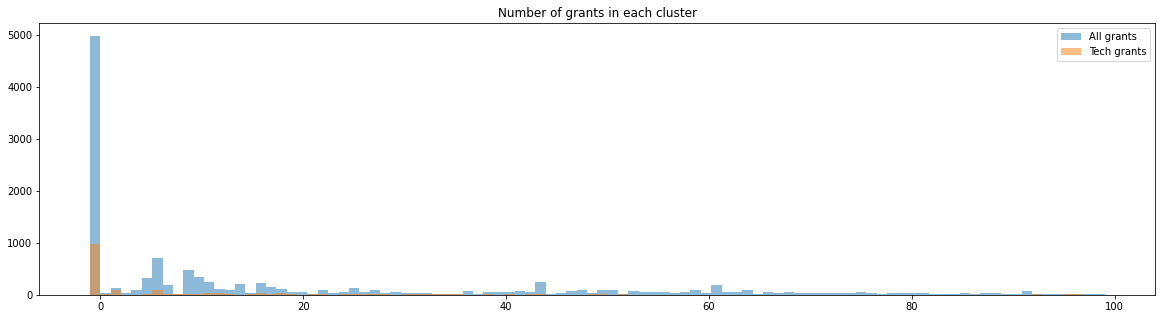

In [13]:
bins = np.linspace(-1, np.max(cluster.cluster_ids), np.max(cluster.cluster_ids))
plt.figure(figsize=(20,5))
a_hist = plt.hist(cluster_grant_data['Cluster number'].tolist(), bins, alpha=0.5, label='All grants')
t_hist = plt.hist(tech_cluster_grant_data['Cluster number'].tolist(), bins, alpha=0.5, label='Tech grants')
plt.legend(loc='upper right')
plt.title('Number of grants in each cluster')
plt.show()

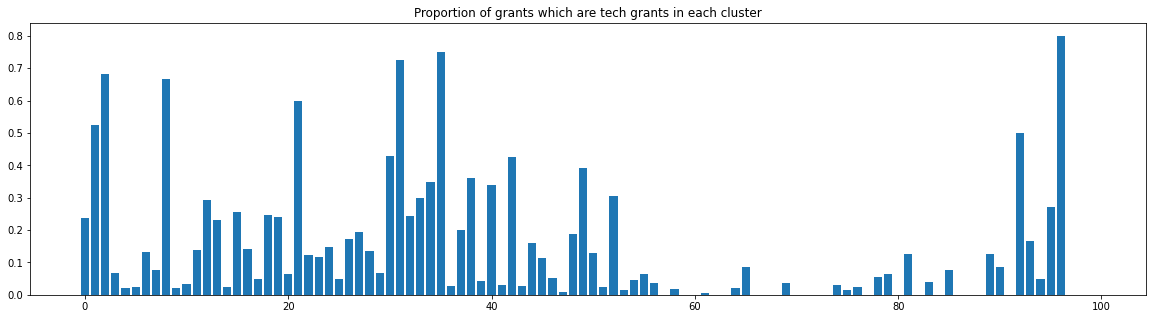

In [14]:
plt.figure(figsize=(20,5))
plt.bar(range(0, np.max(cluster.cluster_ids)+1), tech_props)
plt.title('Proportion of grants which are tech grants in each cluster')
plt.show()

In [23]:
# cluster_plot(cluster, cluster_grant_data, cluster_kws=get_kw_n(cluster_kws,2), cluster_centroids=cluster_centroids)
cluster_plot(cluster, cluster_grant_data, cluster_kws=get_kw_n(cluster_kws,2), cluster_centroids=cluster_centroids, label_font_size=14, save_html=True, datestamp=datestamp)

In [24]:
#cluster_plot(cluster, cluster_grant_data, colour_by = 'tech_or_not', cluster_kws=get_kw_n(cluster_kws,2), cluster_centroids=cluster_centroids, alpha=0.2)
cluster_plot(cluster, cluster_grant_data,  colour_by = 'tech_or_not', cluster_kws=get_kw_n(cluster_kws,2), cluster_centroids=cluster_centroids, label_font_size=14, alpha=0.2, save_html=True, datestamp=datestamp)

In [25]:
#cluster_plot(cluster, cluster_grant_data, colour_by = 'techy grant', cluster_kws=get_kw_n(cluster_kws,3), cluster_centroids=cluster_centroids, alpha=0.2)
cluster_plot(cluster, cluster_grant_data,  colour_by = 'techy grant', cluster_kws=get_kw_n(cluster_kws,3), cluster_centroids=cluster_centroids, label_font_size=14, alpha=0.2, save_html=True, datestamp=datestamp)

In [26]:
#cluster_plot(tech_cluster, tech_cluster_grant_data, colour_by = 'tech_cluster', cluster_kws=get_kw_n(tech_cluster_kws,3), cluster_centroids=tech_cluster_centroids, alpha=0.7)
cluster_plot(tech_cluster, tech_cluster_grant_data,  colour_by = 'tech_cluster', cluster_kws=get_kw_n(tech_cluster_kws,3), cluster_centroids=tech_cluster_centroids, label_font_size=14, alpha=0.7, save_html=True, datestamp=datestamp)

In [22]:
for cluster_num in list(set(cluster.cluster_ids)):
    cluster_idx = [i for i, c_num in enumerate(cluster.cluster_ids) if c_num==cluster_num]
    cluster_tech_numbers = len(cluster_grant_data.iloc[cluster_idx].loc[cluster_grant_data['Tech grant?']])
    cluster_prop_tech = cluster_tech_numbers/cluster_numbers[cluster_num]
    cluster_tech_info.append(
        {
            'Cluster number': cluster_num,
            'Keywords':cluster_kws[cluster_num],
            'Number grants':cluster_numbers[cluster_num],
            'Number tech grants':cluster_tech_numbers,
            'Proportion tech grants': cluster_prop_tech
        }
    )
cluster_tech_info = pd.DataFrame(cluster_tech_info).sort_values('Proportion tech grants', ascending=False)

In [23]:
cluster_tech_info.head(10)

,Cluster number,Keywords,Number grants,Number tech grants,Proportion tech grants
96,96,"datum,open,biobank,wgs,ome,access,software,pla...",20,16,0.800000
35,35,"pregnancy,alspac,datum,birth,participant,study...",20,15,0.750000
31,31,"sequence,genome,datum,method,variation,analysi...",29,21,0.724138
2,2,"genetic,variant,disease,association,study,geno...",135,92,0.681481
8,8,"fetal,maternal,association,cardiovascular,preg...",15,10,0.666667
21,21,"summary,translation,available,award,strategic,...",25,15,0.600000
1,1,"epilepsy,seizure,brain,epileptic,model,patient...",42,22,0.523810
92,92,"care,health,intervention,child,kenya,hospital,...",20,10,0.500000
30,30,"asthma,airway,copd,asm,cell,corticosteroid,lun...",42,18,0.428571
42,42,"intervention,trial,cost,health,child,cluster,o...",47,20,0.425532


In [24]:
cluster_tech_info.tail(10)

,Cluster number,Keywords,Number grants,Number tech grants,Proportion tech grants
60,60,"galen,plague,text,greek,edition,medical,commen...",30,0,0.0
80,80,"manuscript,medieval,text,medical,recipe,collec...",27,0,0.0
62,62,"chromosome,meiosis,segregation,cohesin,kinetoc...",63,0,0.0
77,77,"trachomatis,chlamydia,chagas,disease,vaccine,d...",22,0,0.0
73,73,"ribosome,protein,cell,lysosome,sort,membrane,r...",44,0,0.0
72,72,"microtubule,dynein,kinesin,cargo,motor,transpo...",30,0,0.0
71,71,"ca2,schwann,cell,jun,signal,nerve,hair,axonal,...",36,0,0.0
70,70,"hif,hypoxia,oxygen,hypoxic,cell,vhl,response,p...",33,0,0.0
68,68,"secretion,effector,host,salmonella,cell,bacter...",47,0,0.0
63,63,"histone,chromatin,nucleosome,gene,modification...",51,0,0.0


In [25]:
tech_cluster_info = []
for cluster_num in list(set(tech_cluster.cluster_ids)):
    tech_cluster_info.append(
        {
            'Cluster number': cluster_num,
            'Keywords':tech_cluster_kws[cluster_num],
            'Number grants':tech_cluster_numbers[cluster_num]
        }
    )
tech_cluster_info = pd.DataFrame(tech_cluster_info).sort_values('Number grants', ascending=False)

In [26]:
tech_cluster_info.head(10)

,Cluster number,Keywords,Number grants
62,-1,"research,patient,disease,health,clinical,datum...",351
6,6,"brain,model,image,functional,stroke,mri,visual...",149
2,2,"genetic,variant,study,association,analysis,dis...",107
39,39,"pregnancy,risk,cvd,maternal,cardiovascular,gro...",59
30,30,"intervention,care,trial,health,cost,outcome,ef...",56
24,24,"lung,patient,disease,cell,airway,amd,therapy,c...",44
23,23,"health,research,policy,public,network,social,e...",43
8,8,"coronary,heart,cardiac,device,patient,artery,f...",42
1,1,"sequence,genome,datum,variation,method,analysi...",38
27,27,"mental,health,research,people,community,social...",36


### Money spent per cluster

In [ ]:
cluster_grant_data['Amount Awarded float'] = [float(m.replace(',', '')) for m in cluster_grant_data['Amount Awarded']]

In [65]:
# Check that it's all in the same until
cluster_grant_data['Currency'].unique()

array(['GBP'], dtype=object)

In [88]:
money_per_cluster = cluster_grant_data.groupby(['Tech cluster number'])['Amount Awarded float'].agg('mean')
money_per_cluster = pd.Series.to_frame(money_per_cluster)
money_per_cluster['Tech cluster number'] = list(money_per_cluster.index)
money_per_cluster['Keywords'] = [tech_cluster_kws[i] for i in list(money_per_cluster.index)]
money_per_cluster.index = money_per_cluster['Keywords']
money_per_cluster.sort_values('Amount Awarded float', ascending=False, inplace=True)

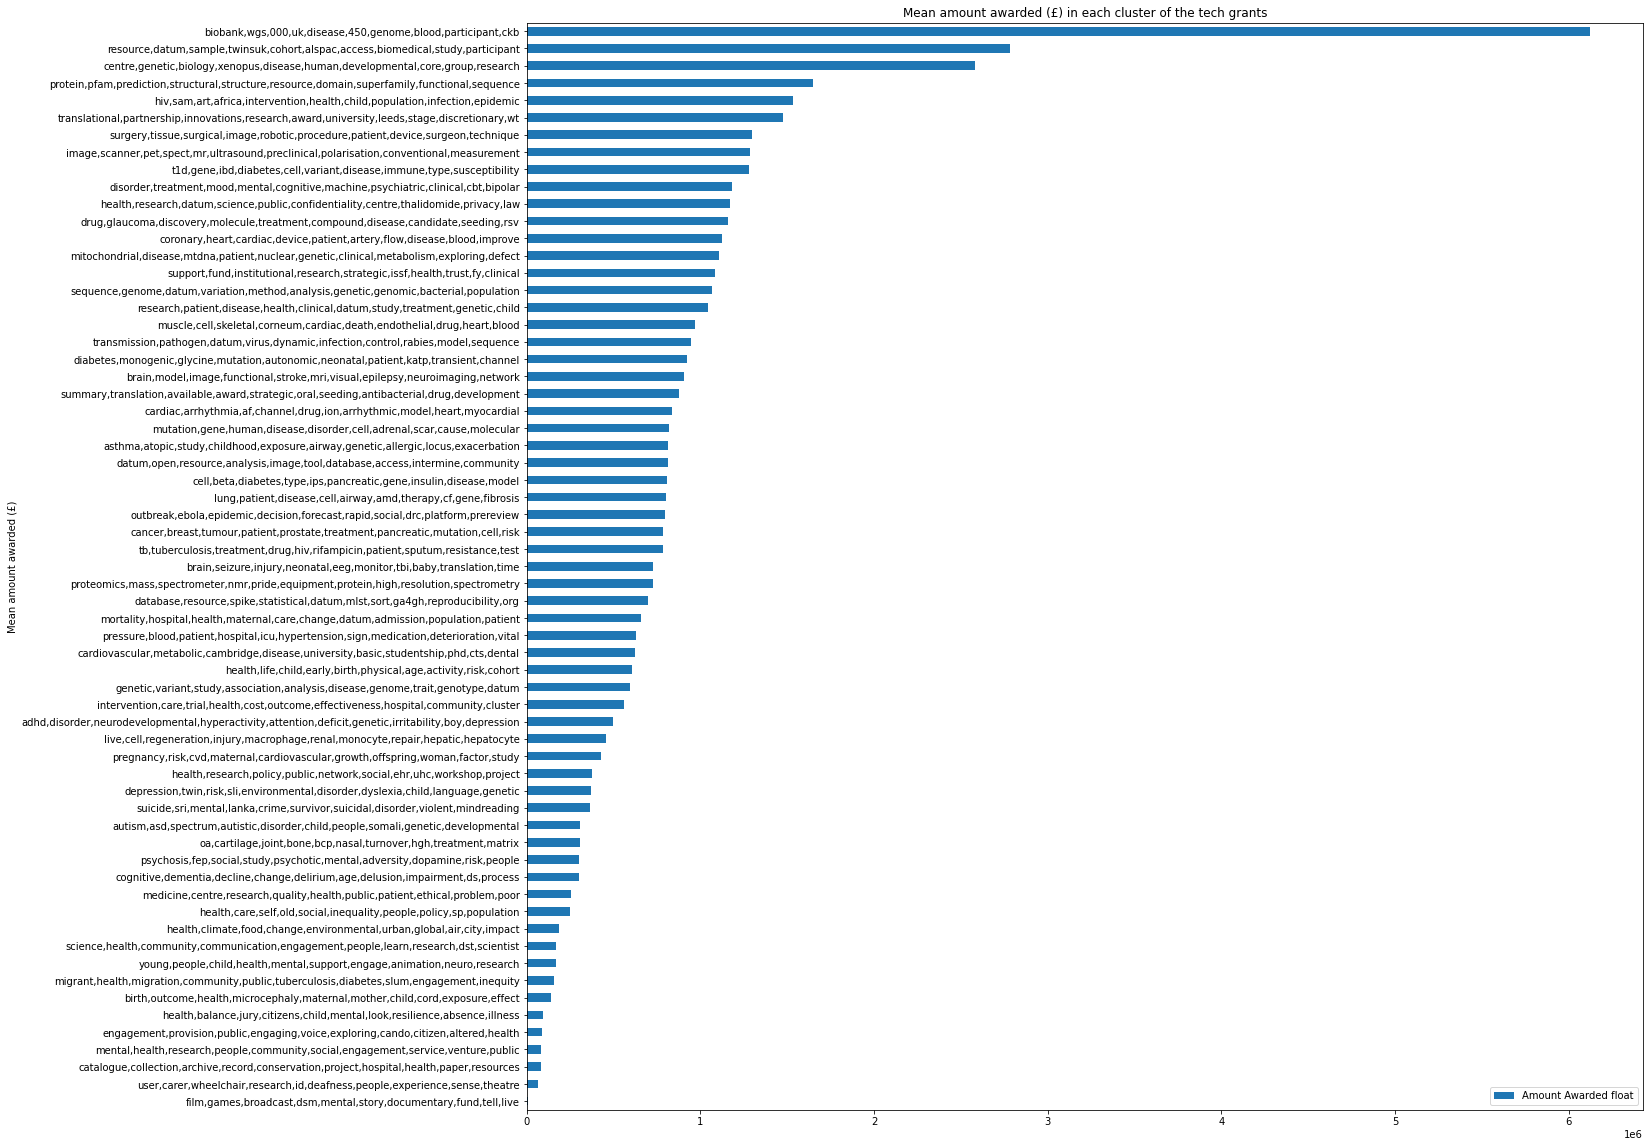

In [106]:
ax = money_per_cluster.iloc[::-1].plot.barh(y='Amount Awarded float', rot=0, figsize=(20,20))
plt.title('Mean amount awarded (£) in each cluster of the tech grants')
plt.ylabel('Mean amount awarded (£)')
plt.show()

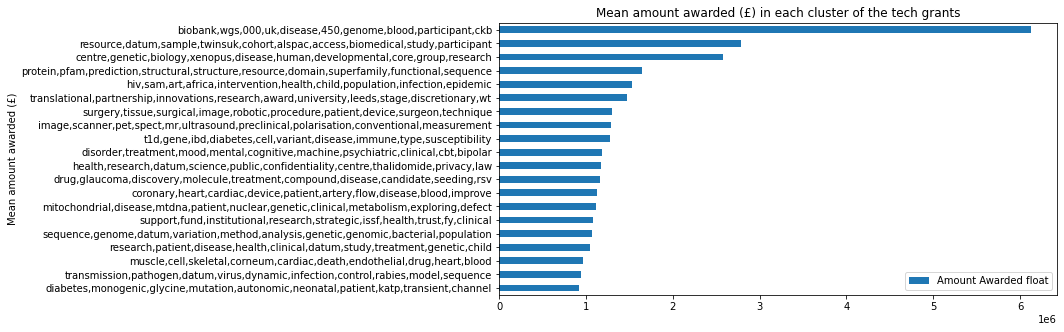

In [108]:
ax = money_per_cluster[0:20].iloc[::-1].plot.barh(y='Amount Awarded float', rot=0, figsize=(10,5))
plt.title('Mean amount awarded (£) in each cluster of the tech grants')
plt.ylabel('Mean amount awarded (£)')
plt.show()

## Biggest grants

In [110]:
cluster_grant_data_sorted = cluster_grant_data.sort_values('Amount Awarded float', ascending=False)

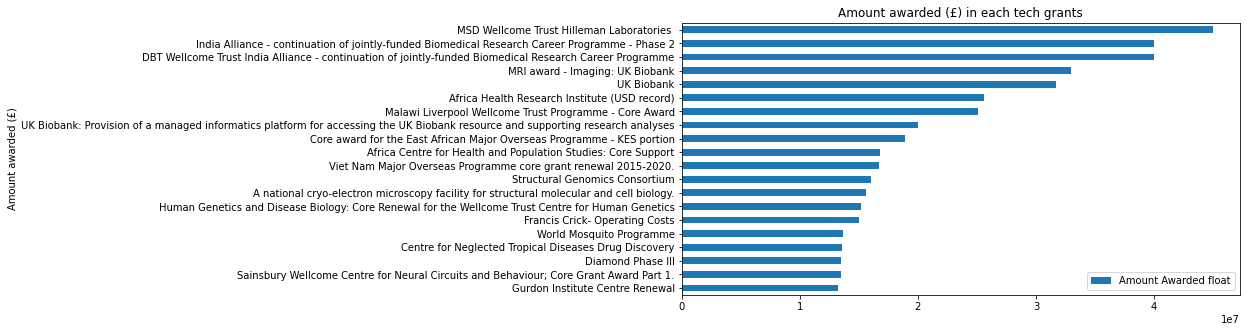

In [116]:
ax = cluster_grant_data_sorted[0:20].iloc[::-1].plot.barh(x='Title',y='Amount Awarded float', rot=0, figsize=(10,5))
plt.title('Amount awarded (£) in each tech grant')
plt.ylabel('Amount awarded (£)')
plt.show()